In [2]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler



### Import CSV and transform 

In [155]:
df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Lösche unnötige Spalte
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Datum als Index
df = df[df.Date <= "2021-12-01"]  #Alles vor 2022
df = df.drop(columns=["Date"], axis = 1)
df["grain_starch_output_price"] = pd.to_numeric(df.grain_starch_output_price)
df = df.iloc[:,0:3].pct_change()            # Deduct daily percent change dataframe from absolute datafram
df = df.dropna()                            
df



,Food_Price,Air_Temperature,grain_starch_output_price
Date,,,
1996-02-01,0.008011,-0.226950,0.001145
1996-03-01,0.007947,-1.458716,0.003432
1996-04-01,0.003942,7.400000,0.001140
1996-05-01,-0.002618,0.327381,0.011390
1996-06-01,-0.001312,0.403587,0.006757
...,...,...,...
2021-08-01,0.000000,-0.107240,0.006573
2021-09-01,0.000000,-0.075610,0.009328
2021-10-01,0.000000,-0.364776,0.042514


### Plot Food-Price

<Axes: xlabel='Date'>

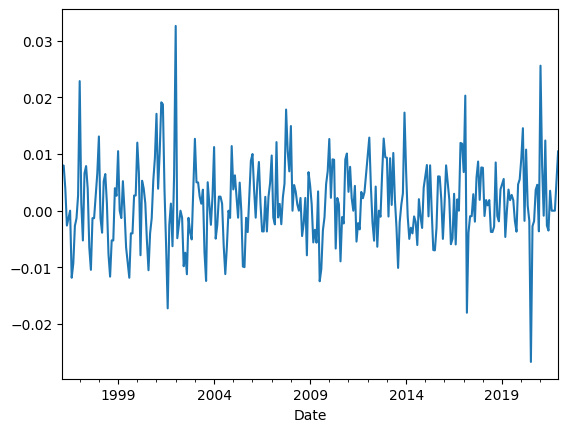

In [156]:
price = df["Food_Price"]
price.plot()


### Erstelle Sliding-Window Arrays

In [157]:
def df_to_X_y(df, window_size=5): #gebe DataFrame und Zeitraum der zu berücksichtigenden Perioden für Vorhersage an 
    df_as_np = df.to_numpy()
    X = [] # Vergangene Werte für Vorhersage
    y = [] # Labels für zu vorhersagende Periode

    for i in range(len(df_as_np)-window_size): #Iteration über numpy-Liste der Werte abzüglich window size
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)          #Gebe Zeitreihe für X und y zurück

#### Überprüfe Format 

In [158]:
window = 9
X, y = df_to_X_y(df, window)
X.shape, y.shape

((302, 9, 3), (302,))

#### Erstelle Test-Train Split

In [160]:
X_train, y_train = X[:250], y[:250]
X_val, y_val = X[250:275], y[250:275]
X_test, y_test = X[275:], y[275:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  #Überprüfufe Form der Splits

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

## Model-Definition & Training

### Erstelle LSTM-Model with Tensorflow

In [218]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model5 = Sequential()
model5.add(LSTM(64, activation='relu', input_shape=(window, 3), return_sequences=True))
model5.add(LSTM(32, activation='relu', return_sequences=False))
model5.add(Dropout(0.1))
model5.add(Dense(1))

model5.compile(optimizer='adam', loss='mse')
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 9, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Anweisung, dass nur bestes Modell nach Training gespeichert werden soll

In [219]:

cp6 = ModelCheckpoint("model5/", save_best_only = True) #Speichere nur bestes Modell mit niedrigstem MeanSqúaredError
model5.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["RootMeanSquaredError"])

### Model Training mit Training und Validation Dataset

In [220]:
model5.fit(X_train, y_train, epochs=600, validation_data = (X_val,y_val), batch_size=32, verbose=0, callbacks=[cp6])



INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


### Lade beste Modelle aus Training

In [221]:
from tensorflow.keras.models import load_model
model5 = load_model('model5/')


## Vorhersage & Performance



Training-MAPE 405.796875
Validation-MAPE 473.4827880859375
Test-MAPE 212.92466735839844


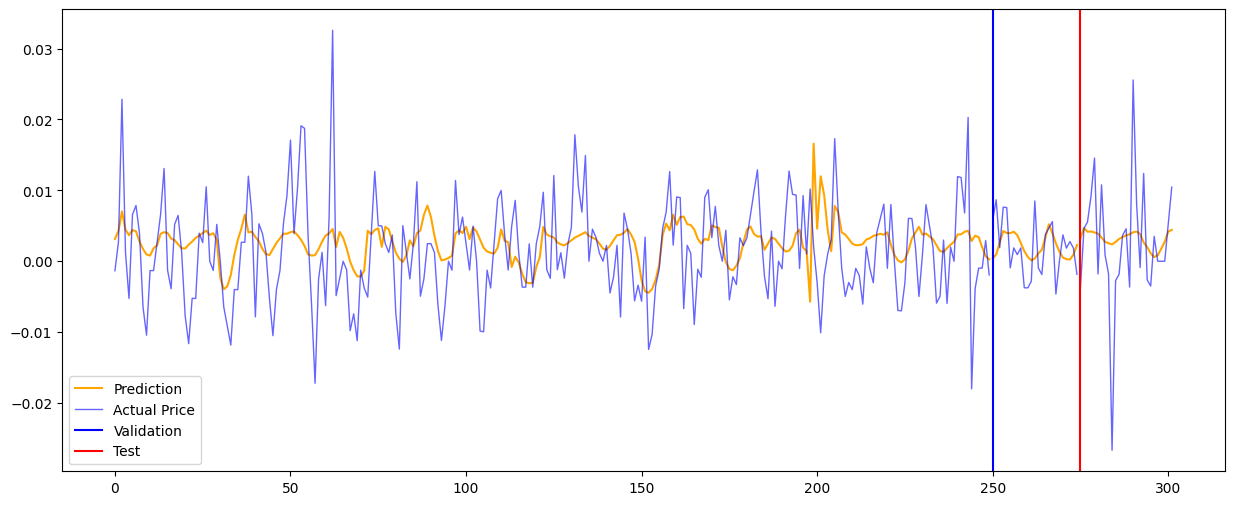

In [237]:
plt.figure(figsize=(15,6))
plt.plot(train_results['Train Predictions'],label='Prediction', color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price', color = "b",alpha=0.6, linewidth = 1.0)
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Validation Predictions'],color = 'orange')
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Actuals'], color = "b", alpha=0.6, linewidth = 1.0)
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Test Predictions'], color = "orange")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Actuals'],color = "b", alpha=0.6, linewidth = 1.0)
plt.axvline(x = 250, color = 'b', label = 'Validation')
plt.axvline(x = 275, color = 'r', label = 'Test')
plt.legend()
plt.legend()

print(f"Training-MAPE {tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])}")
print(f"Validation-MAPE {tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])}")
print(f"Test-MAPE {tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])}")


### Training Data-Set isolierte Ansicht

In [223]:
train_predictions = model5.predict(X_train).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals': y_train}) 
train_results

tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])  #Mean Absolute percentage Error

8/8 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=405.79688>

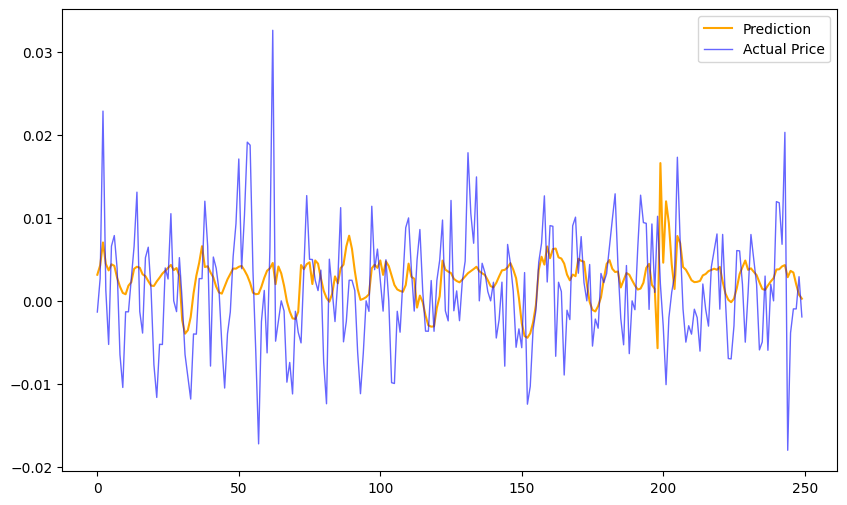

In [229]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(train_results['Train Predictions'],label='Prediction',color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price',color = "b",alpha=0.6, linewidth = 1.0)
plt.legend()



### Validation Data-Set islolierte Ansicht

In [225]:
val_predictions = model5.predict(X_val).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions,'Actuals': y_val}) 
val_results

tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=473.4828>

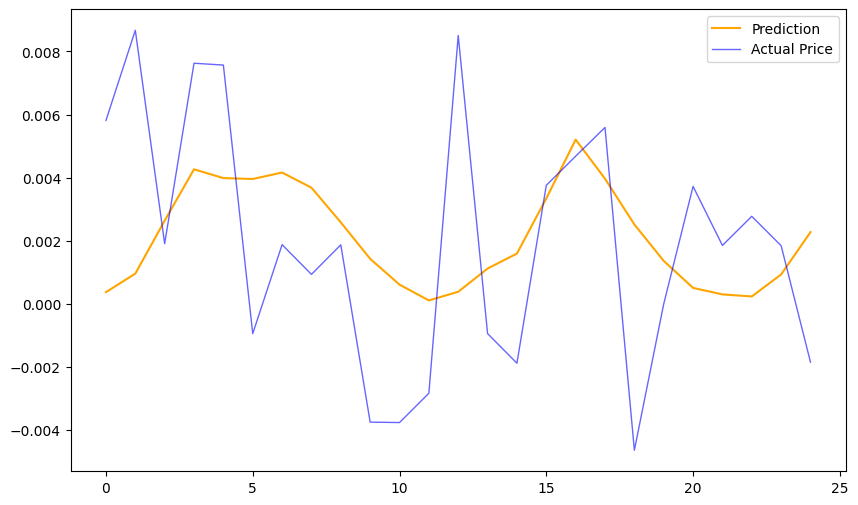

In [226]:
plt.figure(figsize=(10,6))
plt.plot(val_results['Validation Predictions'],label='Prediction', color = "orange")
plt.plot(val_results['Actuals'],label='Actual Price',color = "b",alpha=0.6, linewidth = 1.0)
plt.legend()


### Test Data-Set isolierte Ansicht

In [227]:
test_predictions = model5.predict(X_test).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals': y_test}) 
test_results

tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=212.92467>

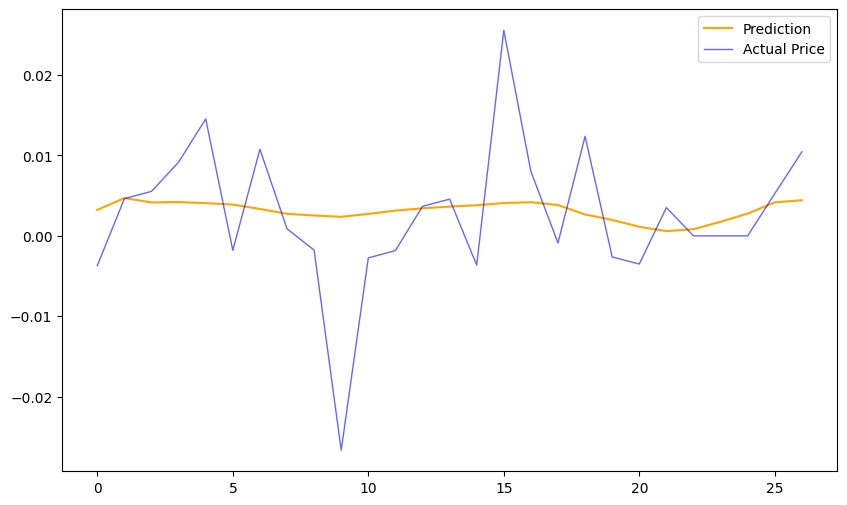

In [228]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Test Predictions'],label='Prediction', color = "orange")
plt.plot(test_results['Actuals'],label='Actual Price',color = "b",alpha=0.6, linewidth = 1.0)
plt.legend()
